In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')


## Reading Data,  Setting Index, Dropping Columns

In [95]:
data = pd.read_csv('data.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index(['timestamp'])
# data = data.resample(rule='10S').mean()
data.head(5)

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [96]:
data = data.drop(['LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses'], axis=1)
data.columns

Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG'],
      dtype='object')

In [53]:
# Preprocessing Class
class Preprocessing:
    """
    1. Read data 
    2. Drop Unnamed: 0 column
    3. Set datetime index
    4. Drop unnecessary columns
    5. Add column status to label the data as healthy(0) and faulty(1)
    """
    def __init__(self):
        self.data = pd.read_csv('data.csv')
        
    def preprocess(self):
        data = self.data.drop(['Unnamed: 0'], axis=1)
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data = data.set_index(['timestamp'])
        data = data.drop(['LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses'], axis=1)
        
        data['status'] = 0
        data.loc[ '4/18/2020 0:00' : '4/18/2020 23:59' ,'status'] = 1 
        data.loc[ '5/29/2020 23:30' : '5/30/2020 6:00' ,'status'] = 1
        data.loc[ '6/5/2020 10:00' : '6/7/2020 14:30' ,'status'] = 1 
        data.loc[ '7/15/2020 14:30' : '7/15/2020 19:00' ,'status'] = 1 
        
        data.to_csv("preprocessed.csv")
        

In [54]:
Preprocessing().preprocess()

## Smoothing The Data For Trend Analysis
**Simple moving average for rolling window 50 is used. 50 means 50x10 seconds = 500 seconds**

In [97]:
data_smooth = data.ewm(com=50).mean()

In [98]:
data_smooth = data_smooth.dropna()

**DATA VISULALISATION WITHIN A HEALTHY WINDOW**

In [99]:
def plot_data(data, data_smooth, start, end):
    plot_data = data[start: end]
    plot_data_smooth = data_smooth[start:end]
    for column in plot_data.columns:
        plt.figure(figsize=(20,5))
        sns.lineplot(data=plot_data, x=plot_data.index, y=plot_data[column])
        sns.lineplot(data=plot_data_smooth, x=plot_data_smooth.index, y=plot_data_smooth[column])
        plt.title(f"Trend of Feature {column}")
        plt.xlabel("Datetime")
        plt.show()

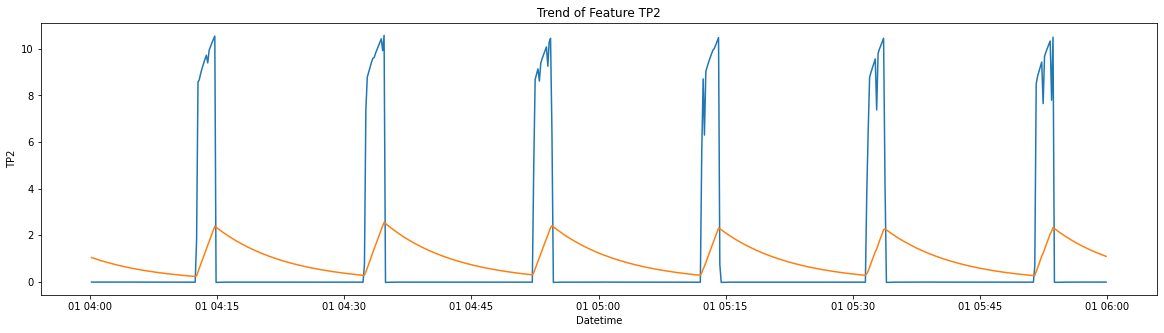

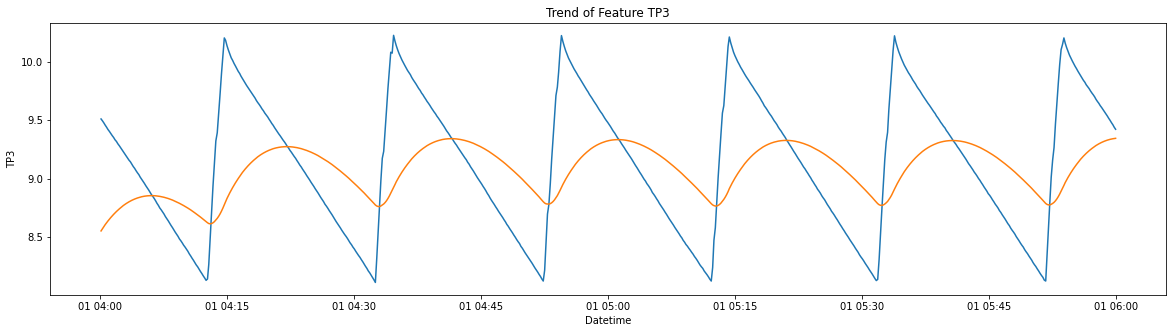

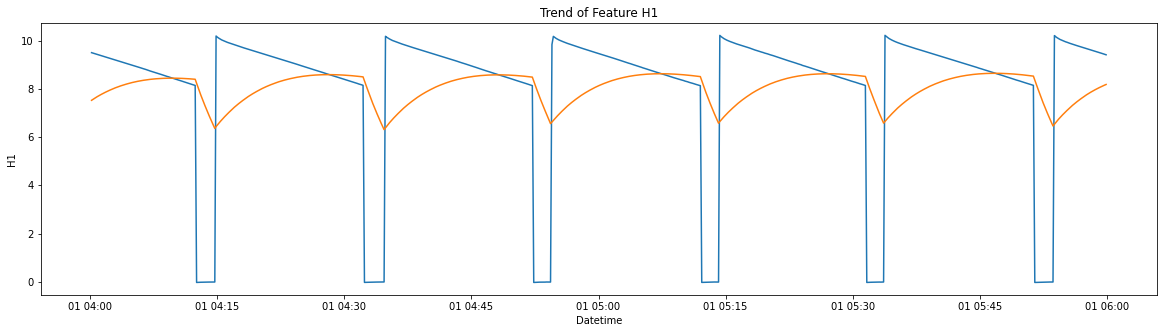

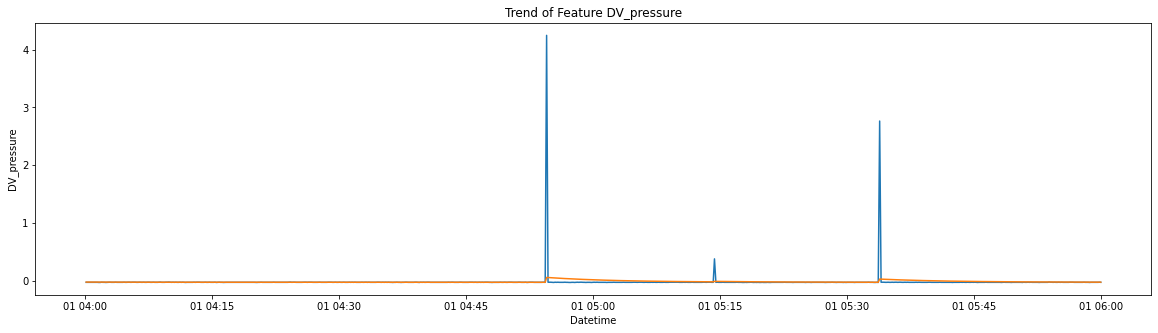

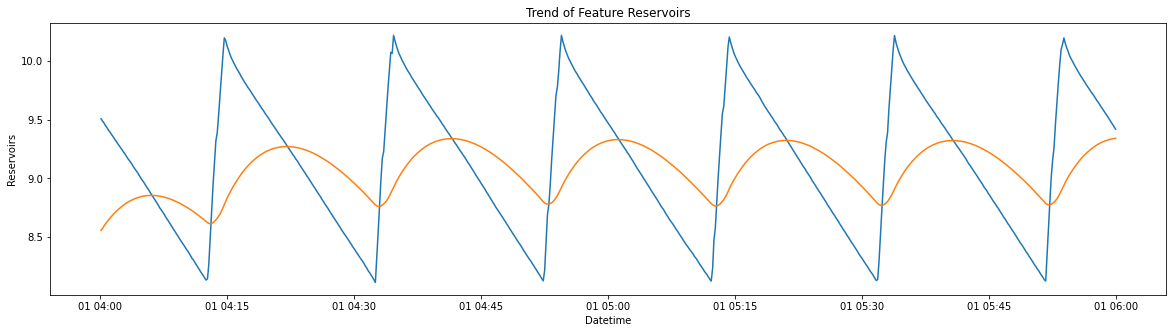

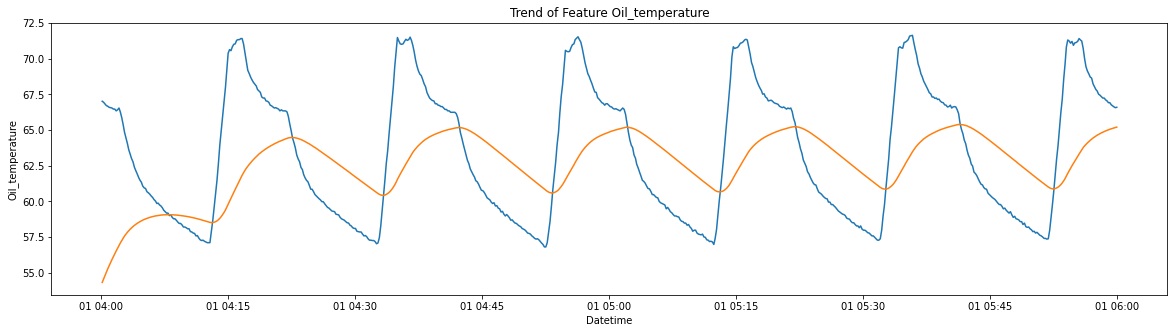

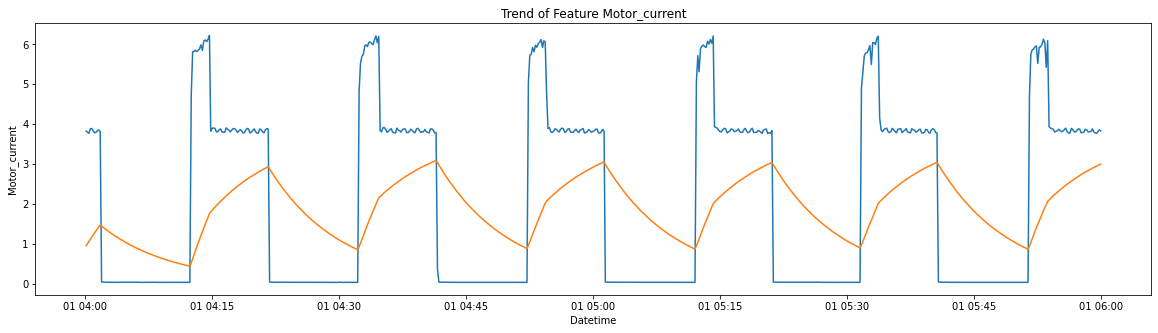

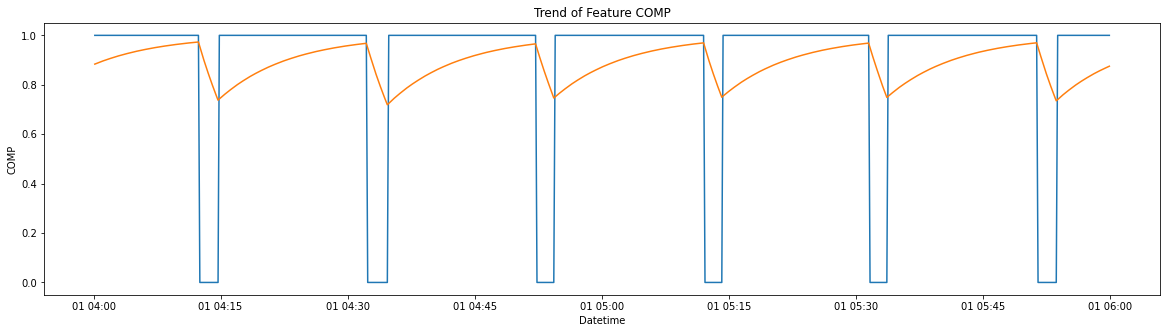

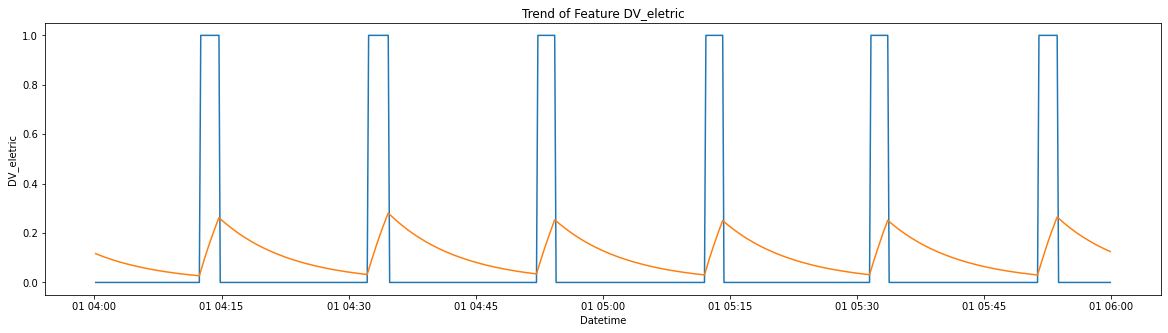

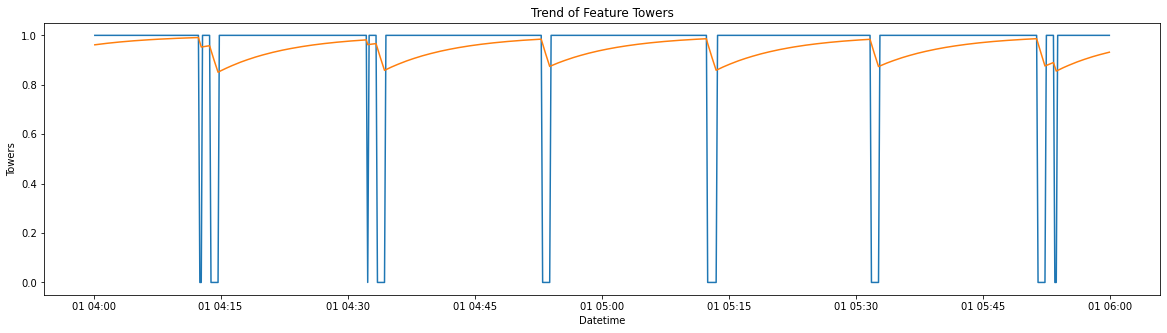

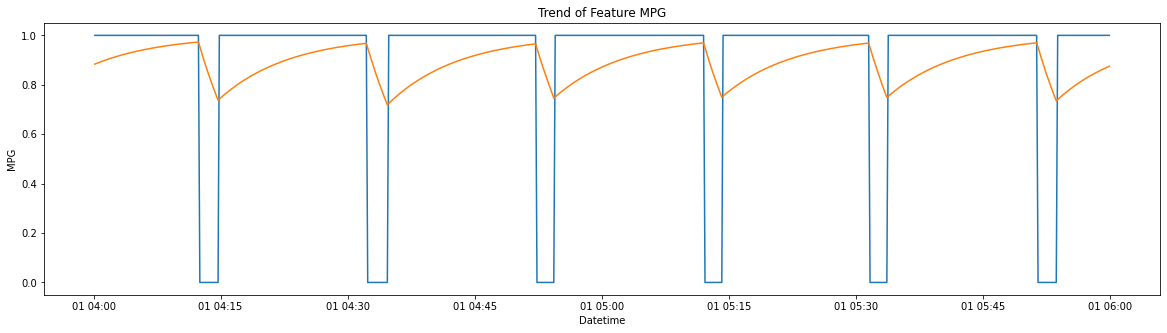

In [100]:
plot_data(data, data_smooth, start=datetime(2020,3,1,0,0), end=datetime(2020,3,1,6,0))

**DATA VISULALISATION WITHIN A HEALTHY + UNHEALTHY WINDOW**

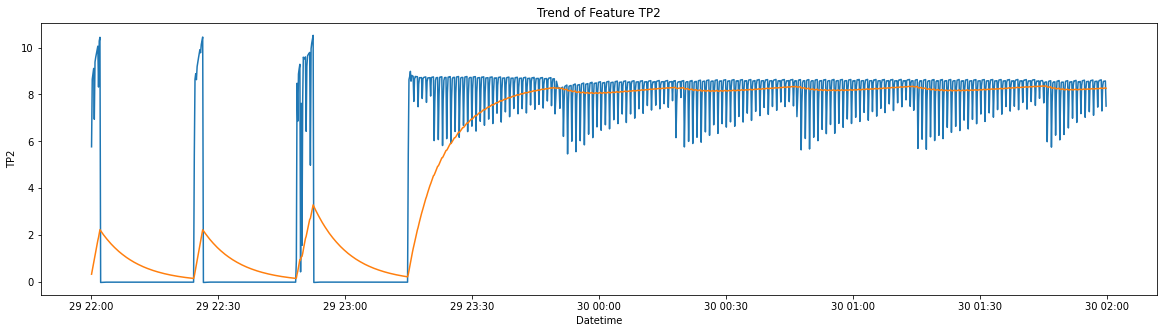

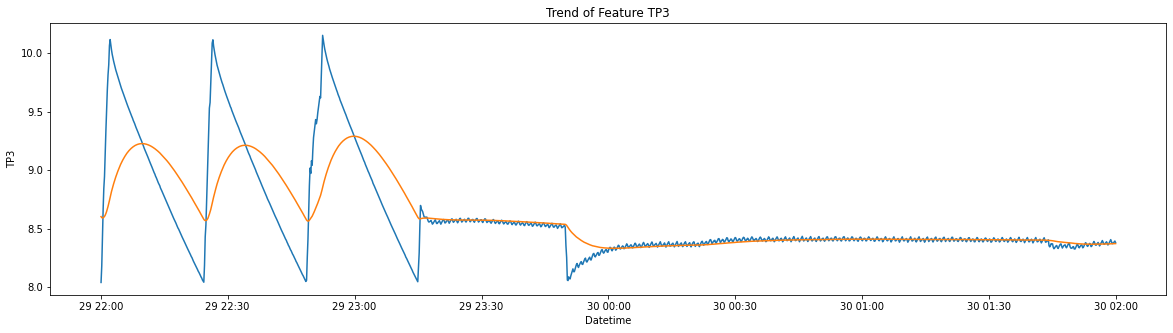

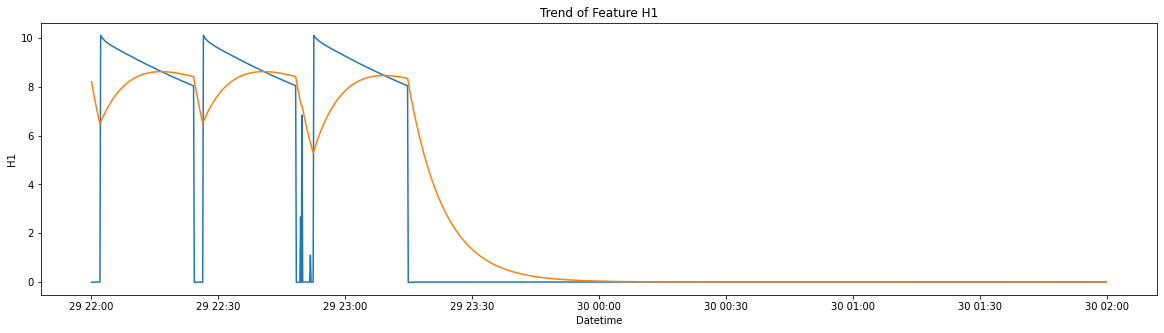

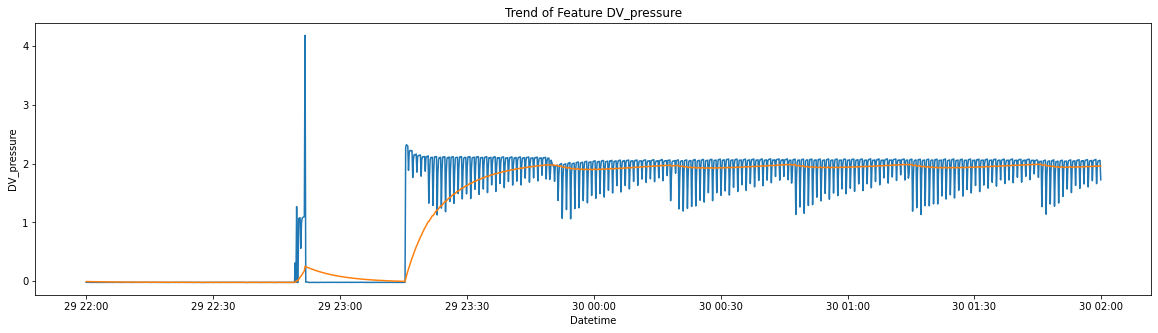

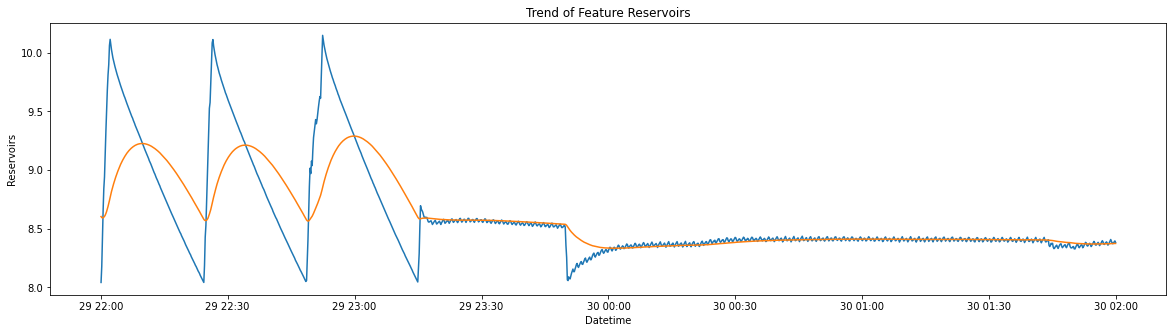

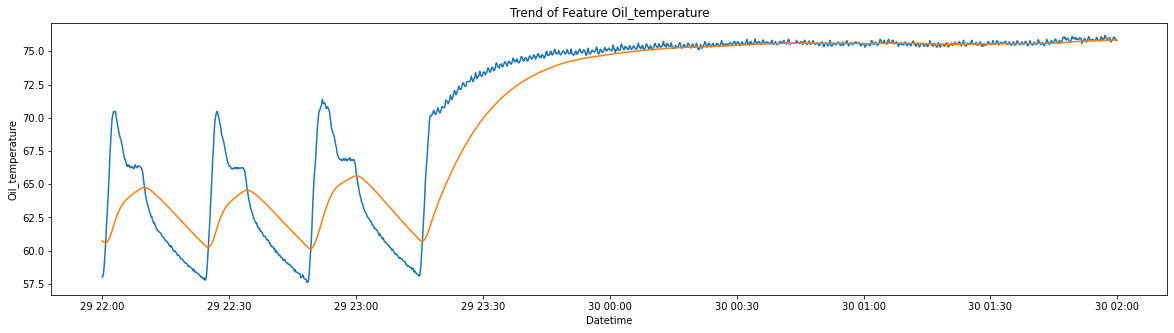

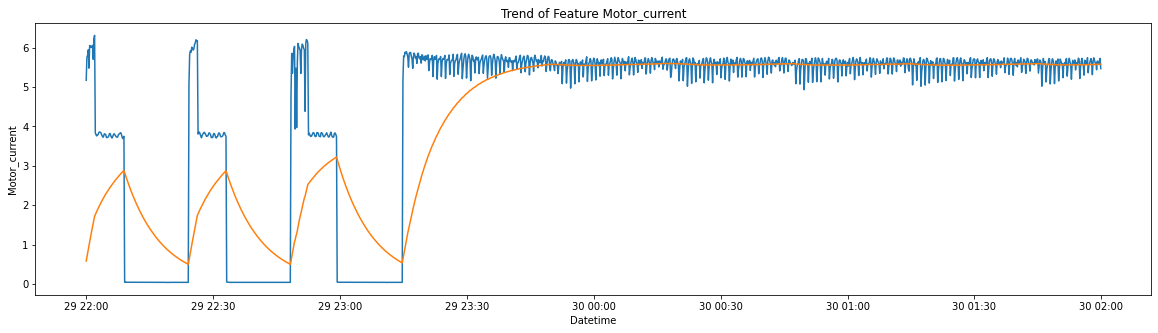

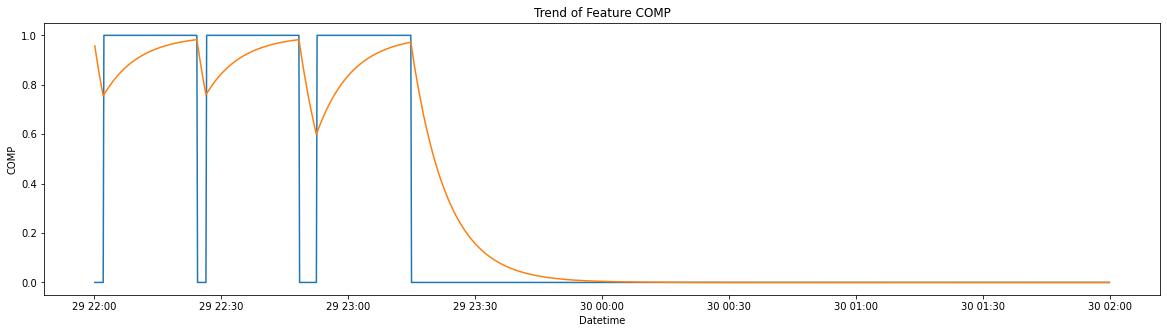

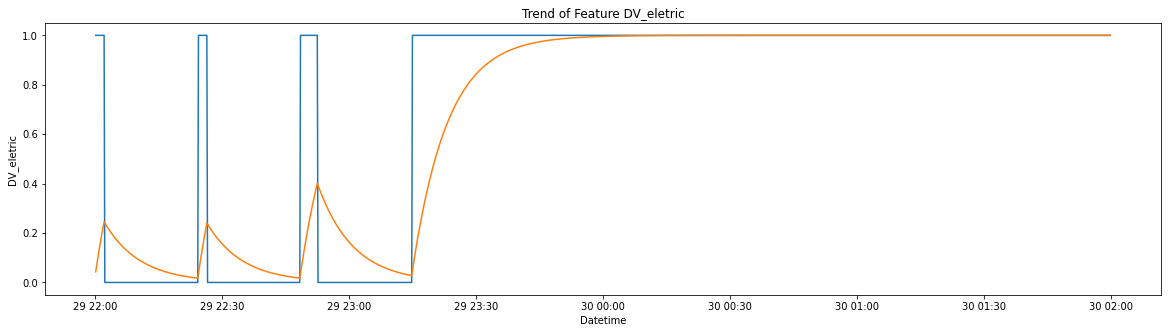

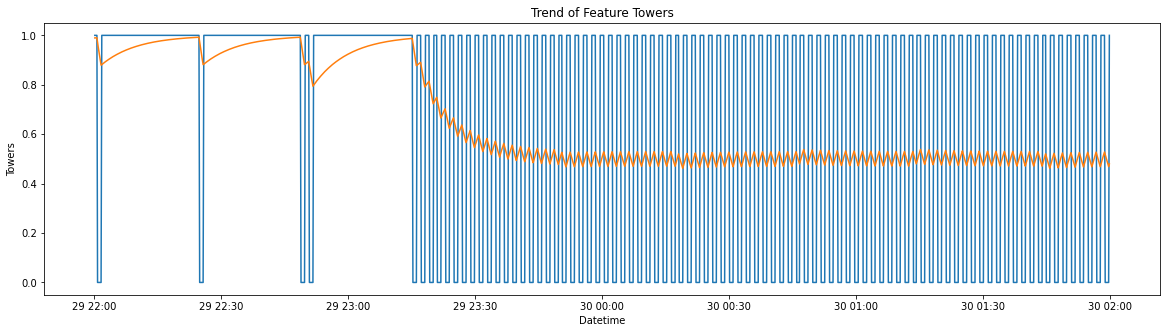

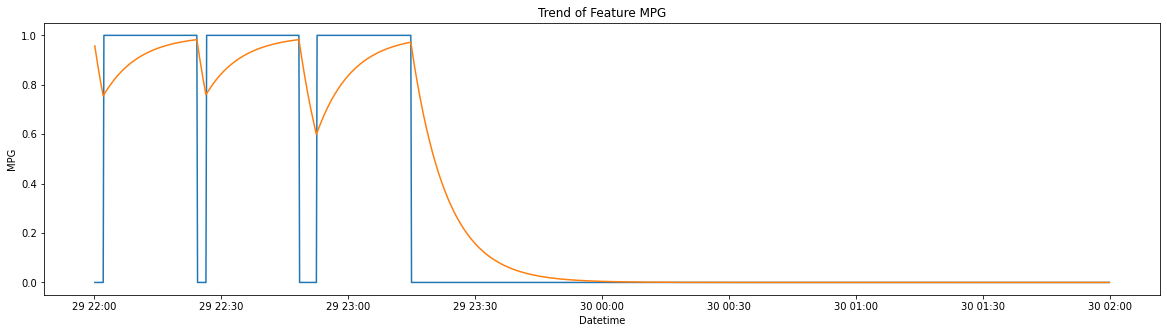

In [94]:
plot_data(data, data_smooth, start=datetime(2020,5,29,22,0), end=datetime(2020,5,30,2,0))

## Label The Data - Do Clustering to Detect Fault
**Healthy data moving average trends are different from unhealthy. So, we will try to do form 2 clusters to separate healthy and unheathy data**

**Here our approach is to minimise false negatives - NO FAULT EVENTS SHOULD BE MISCLASSIFIED AS HEALTHY**

**Flase alarms of false positives are accepted**

In [101]:
# Scale the data 
scaler = StandardScaler()
scaler.fit(data_smooth)
data_scaled = pd.DataFrame(scaler.transform(data_smooth), columns=data_smooth.columns, index = data_smooth.index)
data_scaled.head(5)

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG
timestamp,,,,,,,,,,,
2020-02-01 00:00:00,-0.750654,1.089402,0.886472,-0.228071,1.088443,-1.595659,-1.562794,0.739375,-0.736575,0.777807,0.73168
2020-02-01 00:00:10,-0.751203,1.074670,0.884451,-0.225190,1.073699,-1.588977,-1.562794,0.739375,-0.736575,0.777807,0.73168
2020-02-01 00:00:19,-0.751016,1.059841,0.882076,-0.224230,1.058859,-1.591249,-1.562133,0.739375,-0.736575,0.777807,0.73168
2020-02-01 00:00:29,-0.750923,1.044916,0.879601,-0.223750,1.043922,-1.600334,-1.562303,0.739375,-0.736575,0.777807,0.73168
2020-02-01 00:00:39,-0.750867,1.029895,0.877076,-0.223462,1.028889,-1.603949,-1.562405,0.739375,-0.736575,0.777807,0.73168


In [102]:
data_scaled['status'] = 'Healthy'
data_scaled.loc[ '4/18/2020 0:00' : '4/18/2020 23:59' ,'status'] = 'Air Leak' 
data_scaled.loc[ '5/29/2020 23:30' : '5/30/2020 6:00' ,'status'] = 'Air Leak'
data_scaled.loc[ '6/5/2020 10:00' : '6/7/2020 14:30' ,'status'] = 'Air Leak' 
data_scaled.loc[ '7/15/2020 14:30' : '7/15/2020 19:00' ,'status'] = 'Air Leak' 
data_scaled.head(4)

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,status
timestamp,,,,,,,,,,,,
2020-02-01 00:00:00,-0.750654,1.089402,0.886472,-0.228071,1.088443,-1.595659,-1.562794,0.739375,-0.736575,0.777807,0.73168,Healthy
2020-02-01 00:00:10,-0.751203,1.074670,0.884451,-0.225190,1.073699,-1.588977,-1.562794,0.739375,-0.736575,0.777807,0.73168,Healthy
2020-02-01 00:00:19,-0.751016,1.059841,0.882076,-0.224230,1.058859,-1.591249,-1.562133,0.739375,-0.736575,0.777807,0.73168,Healthy
2020-02-01 00:00:29,-0.750923,1.044916,0.879601,-0.223750,1.043922,-1.600334,-1.562303,0.739375,-0.736575,0.777807,0.73168,Healthy


In [103]:
X = data_scaled.drop(['status'], axis=1)
clustering = KMeans(n_clusters=2, n_init='auto').fit(X.values)
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [104]:
data_scaled['cluster'] = clustering.labels_
data_scaled.head(3)

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,status,cluster
timestamp,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.750654,1.089402,0.886472,-0.228071,1.088443,-1.595659,-1.562794,0.739375,-0.736575,0.777807,0.73168,Healthy,0
2020-02-01 00:00:10,-0.751203,1.074670,0.884451,-0.225190,1.073699,-1.588977,-1.562794,0.739375,-0.736575,0.777807,0.73168,Healthy,0
2020-02-01 00:00:19,-0.751016,1.059841,0.882076,-0.224230,1.058859,-1.591249,-1.562133,0.739375,-0.736575,0.777807,0.73168,Healthy,0


<AxesSubplot:xlabel='cluster', ylabel='count'>

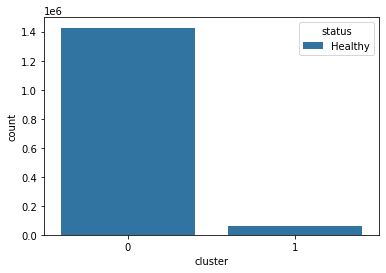

In [105]:
sns.countplot(data_scaled[data_scaled.status=='Healthy'], x='cluster', hue='status')

<AxesSubplot:xlabel='cluster', ylabel='count'>

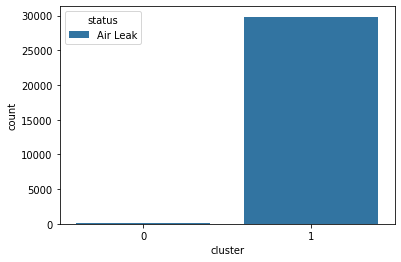

In [106]:
sns.countplot(data_scaled[data_scaled.status=='Air Leak'], x='cluster', hue='status')

In [107]:
# Count False Negatives and False Positives
FN = data_scaled[(data_scaled['status']=='Healthy')&(data_scaled['cluster']==1)]['cluster'].count()
FP = data_scaled[(data_scaled['status']=='Air Leak')&(data_scaled['cluster']==0)]['cluster'].count()
print(f"False Positives  - {FP} and False Negatives - {FN}")

False Positives  - 133 and False Negatives - 59785


In [108]:
# Determining cluster number for healthy and Air Leak
cluster_map = {}

tot_healthy = data_scaled[data_scaled['status']=="Healthy"]['status'].count()
tot_healthy_1 = data_scaled[(data_scaled['status']=="Healthy")&(data_scaled['cluster']==1)]['status'].count()

if (tot_healthy_1/tot_healthy > 0.5):
    cluster_map[1] = "Healthy"
    cluster_map[0] = "Air Leak"
else:
    cluster_map[0] = "Healthy"
    cluster_map[1] = "Air Leak"

cluster_map

{0: 'Healthy', 1: 'Air Leak'}

In [109]:
data_predicted = data_scaled.copy()
data_predicted['cluster'] = data_predicted['cluster'].map(lambda x: cluster_map[x])
data_predicted.head(5)

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,status,cluster
timestamp,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.750654,1.089402,0.886472,-0.228071,1.088443,-1.595659,-1.562794,0.739375,-0.736575,0.777807,0.73168,Healthy,Healthy
2020-02-01 00:00:10,-0.751203,1.074670,0.884451,-0.225190,1.073699,-1.588977,-1.562794,0.739375,-0.736575,0.777807,0.73168,Healthy,Healthy
2020-02-01 00:00:19,-0.751016,1.059841,0.882076,-0.224230,1.058859,-1.591249,-1.562133,0.739375,-0.736575,0.777807,0.73168,Healthy,Healthy
2020-02-01 00:00:29,-0.750923,1.044916,0.879601,-0.223750,1.043922,-1.600334,-1.562303,0.739375,-0.736575,0.777807,0.73168,Healthy,Healthy
2020-02-01 00:00:39,-0.750867,1.029895,0.877076,-0.223462,1.028889,-1.603949,-1.562405,0.739375,-0.736575,0.777807,0.73168,Healthy,Healthy


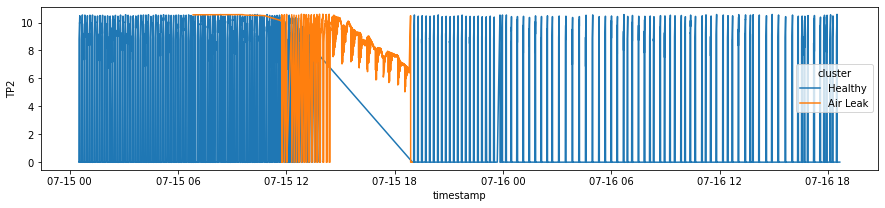

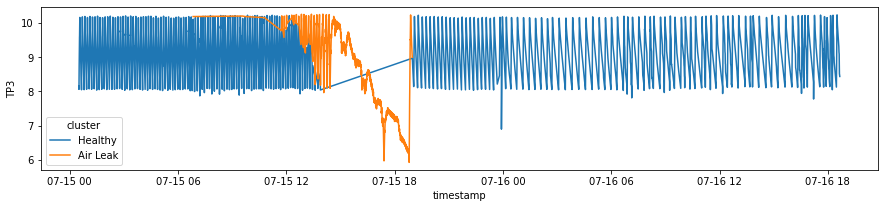

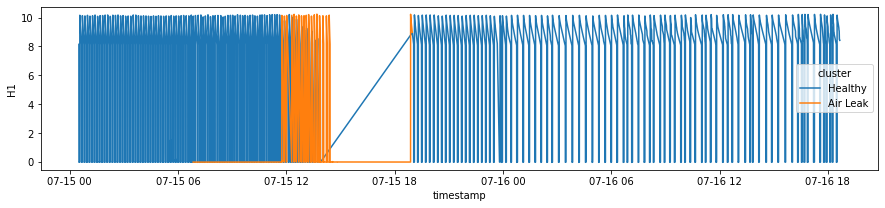

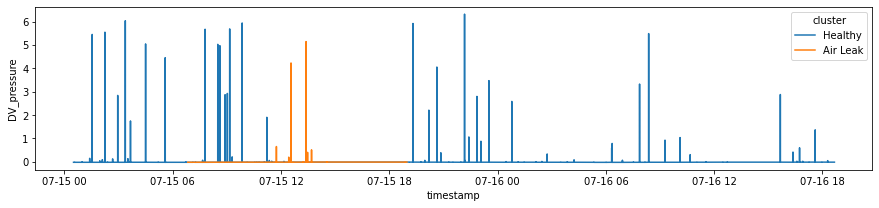

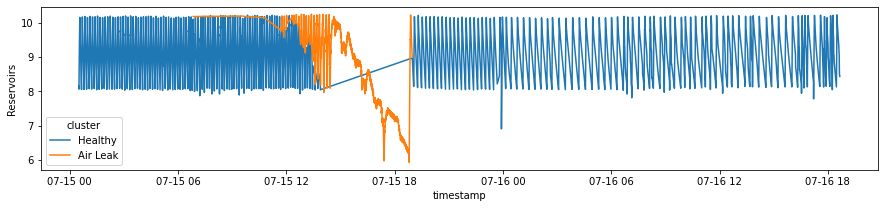

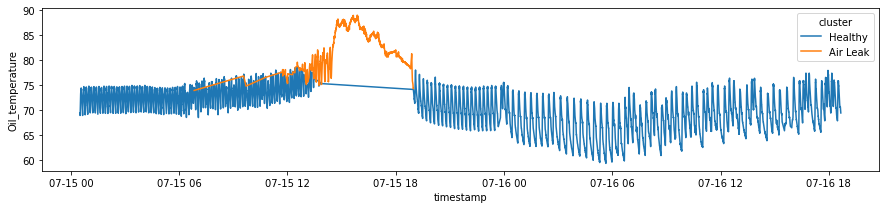

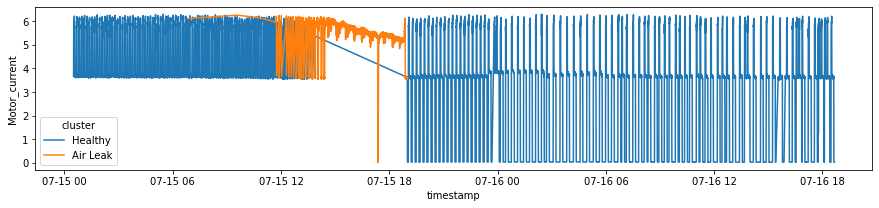

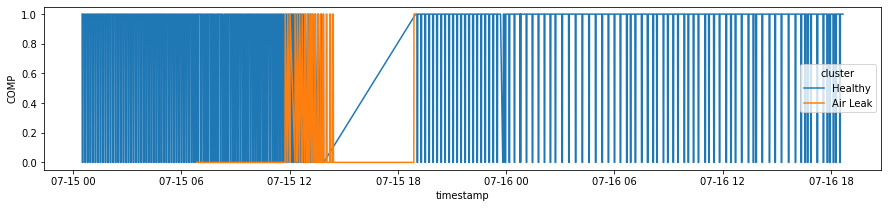

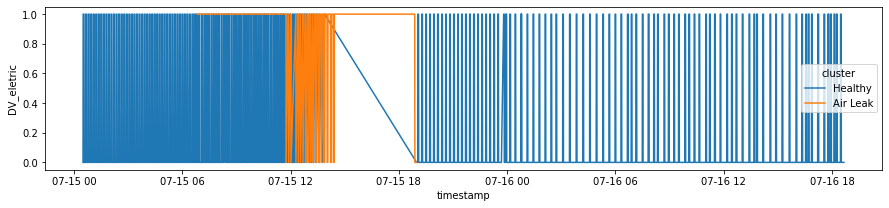

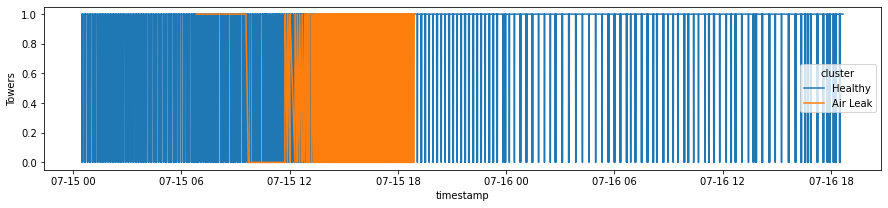

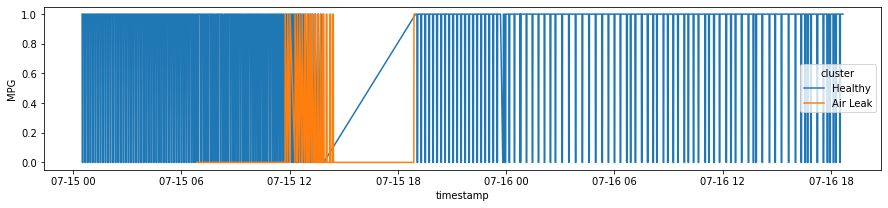

In [111]:
data_slice = data[datetime(2020,7,15,0,30) : datetime(2020,7,16,18,40)]
data_slice_pred = data_predicted[datetime(2020,7,15,0,30) : datetime(2020,7,16,18,40)]
predictions = data_slice_pred['cluster'].values
data_slice.loc[:, ('cluster')] = predictions
for column in data.columns:
    plt.figure(figsize=(15,3))
    sns.lineplot(data_slice, x=data_slice.index, y=column, hue='cluster')
#     sns.scatterplot(data=data_slice_pred, x=data_slice_pred.index, y=column, hue='cluster')
    plt.show()

## The Training Class - Semisupervised Macine Learning Classifier


In [43]:
class Classifier:
    """
    1. Read the preprocessed data
    2. Take the rolling average
    3. Drop the nan values
    4. Split the data in train and test
    6. Train the model
    7. Save the test score - precision and recall
    """
    def __init__(self, rolling_window, method, test_ratio):
        """
        Parameters:
        rolling_window(int) - no. of lags to smoothen the data
        method(str) - "sma" for simple moving average and "ewm" for exponential moving average
        test_ratio(float) - percentage of test data
        """
        self.rolling_window = rolling_window
        self.method = method
        self.test_ratio = test_ratio
        
    
    def fit(self, data):
        """
        Parameter:
        data - the pd dataframe of the training data
        """
        y = data['status']
        X = data.drop(['status'], axis=1)
        
        if self.method == 'sma':
            X = X.rolling(window=self.rolling_window).mean()
        elif self.method == 'ewm':
            X = X.ewm(com=self.rolling_window).mean()
        
        # Drop na vallues from X and corresponding indices of y also
        not_na_idx = X[X.iloc[:,0].notna()].index
        X = X.dropna()
        y = y[not_na_idx]
        

        # Train test split
        total_size = X.shape[0]
        test_size = int(total_size*self.test_ratio)
        X_train, X_test = X.iloc[0:total_size-test_size],X.iloc[total_size-test_size:]
        y_train, y_test = y[0:total_size-test_size],y[total_size-test_size:]
        
        # Scale the data and fit K Means Clustering
        self.scaler = StandardScaler() 
        X_scaled = self.scaler.fit_transform(X_train)
        self.cluster = KMeans(n_clusters=2, n_init='auto' ).fit(X_scaled)
        
        # Find which class belongs to which cluster
        no_of_1 = np.count_nonzero(self.cluster.labels_)
        no_of_0 = self.cluster.labels_.shape[0] - no_of_1
            
        if no_of_1 > no_of_0:
            self.invert_label = True
        else:
            self.invert_label = False
            
        y_test_pred = self.cluster.predict(self.scaler.transform(X_test))
            
        if self.invert_label:
            y_test_pred = 1-y_test_pred
            self.cluster.labels_ = 1 - self.cluster.labels_
            
        # Saving the scoring 
        self.train_recall = recall_score(y_train, self.cluster.labels_)
        self.test_recall  = recall_score(y_test, y_test_pred)
        self.train_precision = precision_score(y_train, self.cluster.labels_)
        self.test_precision = precision_score(y_test, y_test_pred)
        
    def predict(self, X):
        """
        Parameter: X is a pd data frame having only the features
        Description:
        1. It will calculate the rolling average from rolling window
        2. Then scaling will be done
        3. Then it will find the predicted class level (1 - Fault, 0 - Healthy) of the last data point
        4. In case it returns -1 means data frame size is less than the window
        """
        if X.shape[0] < self.rolling_window:
            return -1
        
        # Moving average and drop nan
        if self.method == 'sma':
            X = X.rolling(window=self.rolling_window).mean()
        elif self.method == 'ewm':
            X = X.ewm(com=self.rolling_window).mean()
        X = X.dropna()
        
        query_pt = X.iloc[-1].values.reshape(1,-1) # Last point
        query_pt = self.scaler.transform(query_pt)
        prediction = self.cluster.predict(query_pt)
        
        if self.invert_label:
            prediction = 1 - prediction
        
        return prediction
        
    
preprocessed =  pd.read_csv('preprocessed.csv', index_col='timestamp')
preprocessed.index = pd.to_datetime(preprocessed.index) # Convert index to datetime

model = Classifier(50, "ewm", 0.5)
model.fit(preprocessed)
        

In [90]:
display(f"Test Recall score - {model.test_recall}")
display(f"Train recall score - {model.train_recall}")
display(f"Test precision score - {model.test_precision}")
display(f"Train precision score - {model.train_precision}")

'Test Recall score - 0.9992960390463675'

'Train recall score - 0.9860325522336373'

'Test precision score - 0.3952003563540526'

'Train precision score - 0.24215450035435862'

In [45]:
X = preprocessed.drop(['status'], axis=1)

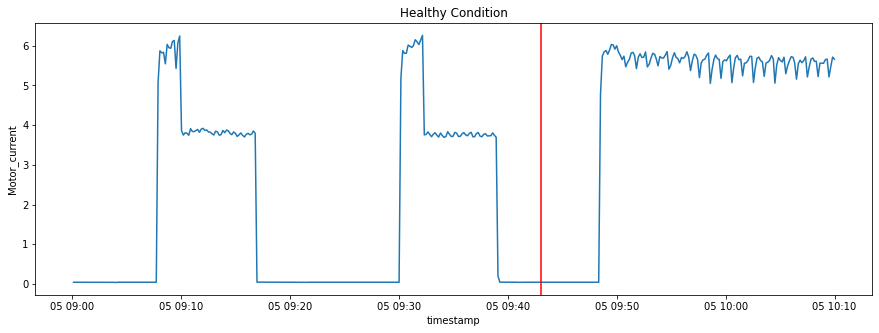

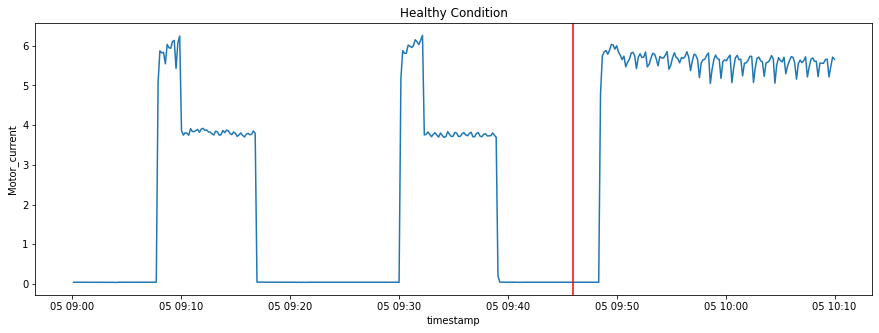

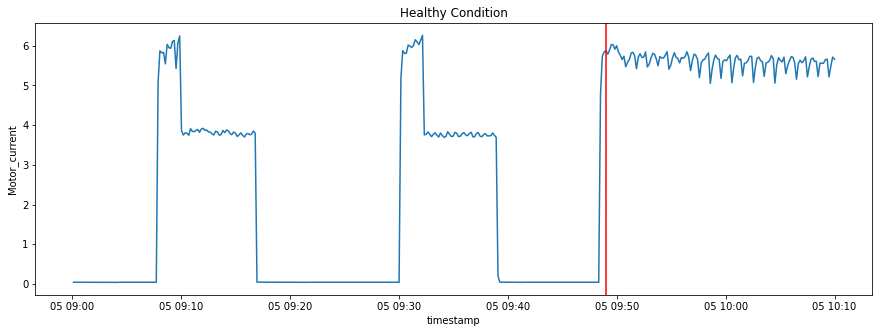

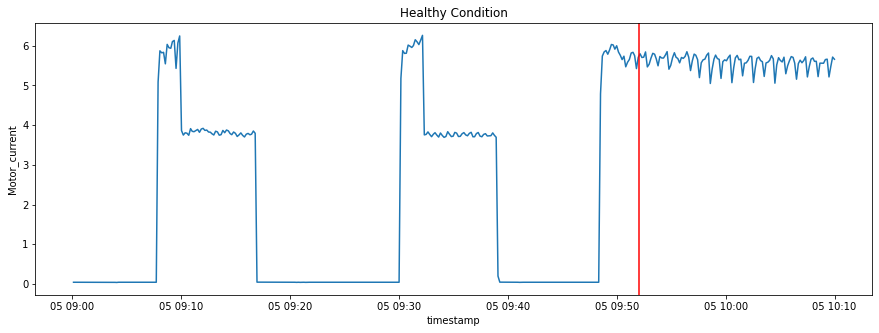

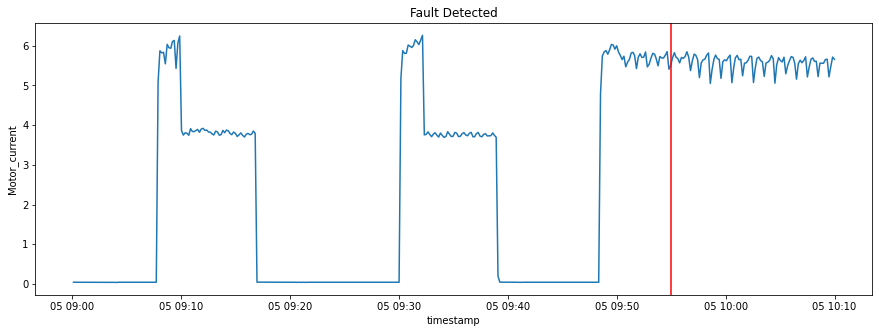

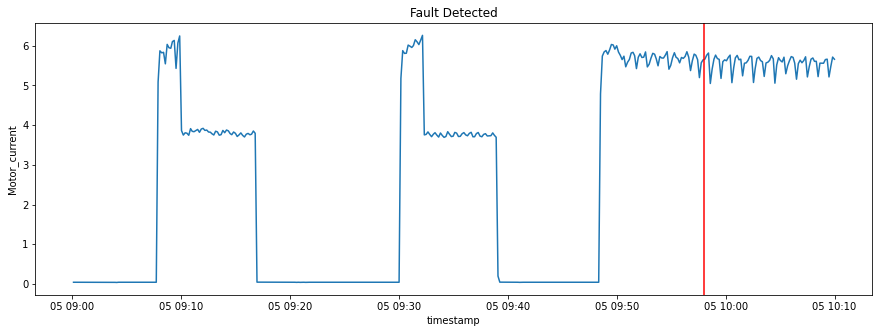

In [88]:
# Test the model on some slice of data
test_data = X[datetime(2020, 6, 5, 9, 0):datetime(2020, 6, 5, 10, 10)]
start = datetime(2020, 6, 5, 9, 40)

for i in range(6):
    try:
        start = start + timedelta(minutes=3)
        query = test_data[:start]
        prediction = model.predict(query)
        
        plt.figure(figsize=(15,5))
        if prediction == 1:
            plt.title("Fault Detected")
        else:
            plt.title("Healthy Condition")
        sns.lineplot(test_data['Motor_current'])
        plt.axvline(x=start, color='red')
        plt.show()
        
    except:
        break